对应 `tf.keras` 的01~02章节

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


## 数据准备

In [2]:
# 从torchvision库中导入必要的模块和函数
from torchvision import datasets  # 导入datasets模块，用于加载常见的数据集
from torchvision.transforms import ToTensor  # 导入ToTensor，用于将图像转换为Tensor类型
from torchvision import transforms  # 导入transforms，用于图像的各种转换

# 定义数据集的变换（transform）
transform = transforms.Compose([  # 使用Compose组合多个转换操作
    transforms.ToTensor(),  # 转换图像为Tensor格式，且将图像像素归一化到[0, 1]范围
    # transforms.Normalize(mean, std) # 这里可以加上标准化操作，使用数据集的均值和标准差进行归一化处理
])

# FashionMNIST数据集：训练集
train_ds = datasets.FashionMNIST(
    root="data",  # 数据集存储的根目录（下载的文件将保存在data目录下）
    train=True,  # 选择训练集数据
    download=True,  # 如果数据集未下载，则下载
    transform=transform  # 在加载数据时应用上述定义的transform变换
)

# FashionMNIST数据集：测试集
test_ds = datasets.FashionMNIST(
    root="data",  # 数据集存储的根目录（下载的文件将保存在data目录下）
    train=False,  # 选择测试集数据
    download=True,  # 如果数据集未下载，则下载
    transform=transform  # 在加载数据时应用上述定义的transform变换
)

# 提示：torchvision 数据集并没有直接提供训练集和验证集的划分
# 如果需要验证集，通常需要人工划分训练集，例如使用torch.utils.data.random_split来实现


100%|██████████| 26.4M/26.4M [00:03<00:00, 6.82MB/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 122kB/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.27MB/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [3]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [4]:
len(train_ds)

60000

In [5]:
type(train_ds[0])

tuple

In [6]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]
img.shape
# img.shape = (1, 28, 28)，这是因为通道数在最前面

torch.Size([1, 28, 28])

In [7]:
type(img) #tensor中文是 张量,和numpy的ndarray类似

torch.Tensor

In [8]:
img[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510, 0.2863, 0.0000,
         0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000

In [9]:
img

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [10]:
# 定义一个计算均值和方差的函数
def cal_mean_std(ds):
    mean = 0.  # 初始化均值为0
    std = 0.   # 初始化标准差为0
    for img, _ in ds:  # 遍历数据集中的每一张图片，img是图片数据，_是对应的标签（我们不关心标签）
        # `img.mean(dim=(1, 2))`：对每张图像的高度和宽度维度进行求均值（忽略通道维度），返回每个图像的均值
        # `img.std(dim=(1, 2))`：对每张图像的高度和宽度维度进行求标准差（忽略通道维度），返回每个图像的标准差
        mean += img.mean(dim=(1, 2))  # 对每张图片的均值累加
        std += img.std(dim=(1, 2))    # 对每张图片的标准差累加
    mean /= len(ds)  # 将均值总和除以数据集的大小，得到平均均值
    std /= len(ds)   # 将标准差总和除以数据集的大小，得到平均标准差
    return mean, std  # 返回均值和标准差

# 打印计算结果
print(cal_mean_std(train_ds))


(tensor([0.2860]), tensor([0.3205]))


In [11]:
type(img)

torch.Tensor

In [12]:
label

9

In [13]:
# 显示图片，这里需要把transforms.ToTensor(),进行归一化注释掉，否则是不行的
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)


    print("图像大小:", img.size)
    print("图像模式:", img.mode)


    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)
show_img_content(img) #这里必须把上面的 transforms.ToTensor(), # 转换为tensor，进行归一化注释掉，否则是不行的

图像大小: <built-in method size of Tensor object at 0x00000167211420D0>
图像模式: <built-in method mode of Tensor object at 0x00000167211420D0>


TypeError: Invalid shape (1, 28, 28) for image data

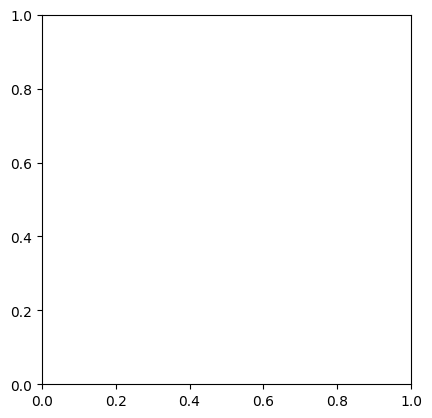

In [14]:
#这个代码必须是注释了上面的 transforms.ToTensor()才能够运行的
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary") # 显示图片
    plt.colorbar() # 显示颜色条
    plt.show()


show_single_image(img)

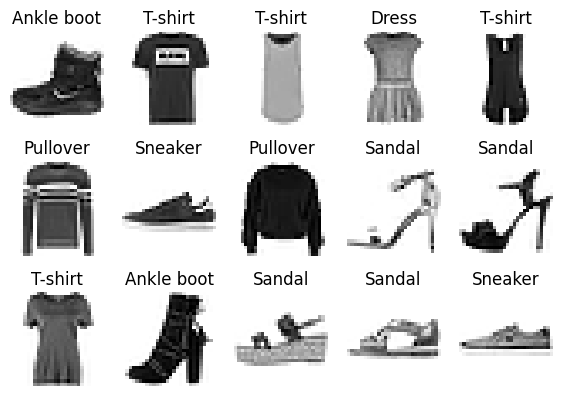

In [15]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    # 确保输入的行列数所表示的图片总数小于数据集中样本数
    assert n_rows * n_cols < len(train_ds), "网格中的图片数量不能超过数据集大小"

    # 设置画布的大小，宽度为列数×1.4，高度为行数×1.6
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    
    # 遍历网格中的每一行和每一列
    for row in range(n_rows):
        for col in range(n_cols):
            # 根据行号和列号计算当前图片的索引
            index = n_cols * row + col
            
            # 创建子图，网格位置从1开始计数
            plt.subplot(n_rows, n_cols, index + 1)
            
            # 从数据集中提取图片数组和标签
            img_arr, label = train_ds[index]
            
            # 将图片数组的通道维度从 (C, H, W) 转换为 (H, W, C)，便于显示
            img_arr = np.transpose(img_arr, (1, 2, 0))
            
            # 显示图片，使用二值色调（灰度色）和最近邻插值方式
            plt.imshow(img_arr, cmap="binary", interpolation='nearest')
            
            # 去掉图片的坐标轴
            plt.axis('off')
            
            # 设置图片的标题为类别名称
            plt.title(class_names[label])
    
    # 展示所有子图
    plt.show()
#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot'] #0-9分别代表的类别
#只是打印了前15个样本
show_imgs(3, 5, train_ds, class_names)

In [16]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(
    train_ds,         # 输入训练数据集 train_ds，应该是一个 Dataset 对象
    batch_size=32,    # 每个批次加载 32 个样本
    shuffle=True      # 在每个 epoch 开始时打乱数据的顺序，这样有助于避免模型对数据顺序的过拟合
)  

val_loader = torch.utils.data.DataLoader(
    test_ds,          # 输入测试数据集 test_ds，应该是一个 Dataset 对象
    batch_size=32,    # 每个批次加载 32 个样本
    shuffle=False     # 测试数据集通常不需要打乱顺序，因为我们只关心每个样本的评估结果
)


在PyTorch中，`DataLoader`是一个迭代器，它封装了数据的加载和预处理过程，使得在训练机器学习模型时可以方便地批量加载数据。`DataLoader`主要负责以下几个方面：

1. **批量加载数据**：`DataLoader`可以将数据集（Dataset）切分为更小的批次（batch），每次迭代提供一小批量数据，而不是单个数据点。这有助于模型学习数据中的统计依赖性，并且可以更高效地利用GPU等硬件的并行计算能力。

2. **数据打乱**：默认情况下，`DataLoader`会在每个epoch（训练周期）开始时打乱数据的顺序。这有助于模型训练时避免陷入局部最优解，并且可以提高模型的泛化能力。

3. **多线程数据加载**：`DataLoader`支持多线程（通过参数`num_workers`）来并行地加载数据，这可以显著减少训练过程中的等待时间，尤其是在处理大规模数据集时。

4. **数据预处理**：`DataLoader`可以与`transforms`结合使用，对加载的数据进行预处理，如归一化、标准化、数据增强等操作。

5. **内存管理**：`DataLoader`负责管理数据的内存使用，确保在训练过程中不会耗尽内存资源。

6. **易用性**：`DataLoader`提供了一个简单的接口，可以很容易地集成到训练循环中。

## 定义模型

In [17]:
# 定义一个神经网络类，继承自 nn.Module 类
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()  # 继承父类 nn.Module 的初始化方法，初始化神经网络的参数和属性
        # 初始化网络的层
        self.flatten = nn.Flatten()  # nn.Flatten() 层将输入的数据展平成一维（例如从 28x28 的二维图像展平为一个向量）

        # 创建一个由多个层堆叠而成的顺序容器 nn.Sequential
        self.linear_relu_stack = nn.Sequential(
            # 第一个全连接层，将 28x28 图像（784 个特征）映射到 300 个特征
            nn.Linear(784, 300),  # 输入特征数 784，输出特征数 300
            nn.ReLU(),            # ReLU 激活函数，增加网络的非线性，使得神经网络能够学习更复杂的模式

            # 第二个全连接层，将 300 个特征映射到 100 个特征
            nn.Linear(300, 100),  # 输入特征数 300，输出特征数 100
            nn.ReLU(),            # 再次应用 ReLU 激活函数，增加非线性

            # 第三个全连接层，将 100 个特征映射到 10 个特征（10 类）
            nn.Linear(100, 10),   # 输入特征数 100，输出特征数 10（每个类别一个输出）
        )

    def forward(self, x):  # 前向计算方法，定义输入数据通过网络传播的过程
        # 输入 x 的形状是 [batch size, 1, 28, 28]，即每个图像的尺寸为 28x28，batch size 是批量大小
        # x 是输入的图像张量，形状为 (batch_size, 1, 28, 28)

        x = self.flatten(x)  # 使用展平层将输入的图像展平成一个一维向量
        # 展平后的 x 形状为 [batch size, 784]，即每个 28x28 的图像被展平为一个 784 维的向量

        logits = self.linear_relu_stack(x)  # 将展平后的输入传入全连接层堆叠
        # logits 的形状是 [batch size, 10]，即每个图像输出一个 10 维的向量，表示 10 个类别的得分（logits）

        return logits  # 返回 logits，表示每个类别的原始得分值，未经过 softmax 的处理
        # logits 通常是在分类任务中直接用作神经网络的输出层，它们代表了每个类别的原始分数，通常需要通过 softmax 函数转化为概率。

# 实例化一个神经网络模型
model = NeuralNetwork()


In [18]:
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [19]:
784*300+300+300*100+100+100*10+10 #计算模型参数数量

266610

In [20]:
# 遍历模型的参数，并打印每个参数的名称和形状
for name, param in model.named_parameters(): 
    # 打印参数的名称和形状
    print(name, param.shape)


linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])


In [21]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数,requires_grad=True

[Parameter containing:
 tensor([[-0.0343, -0.0257,  0.0125,  ..., -0.0085,  0.0006, -0.0232],
         [ 0.0078,  0.0213, -0.0276,  ..., -0.0060,  0.0135,  0.0095],
         [-0.0082,  0.0080, -0.0339,  ...,  0.0164, -0.0068, -0.0206],
         ...,
         [-0.0353, -0.0074,  0.0140,  ...,  0.0221, -0.0105, -0.0064],
         [-0.0110, -0.0233, -0.0298,  ...,  0.0345, -0.0034,  0.0166],
         [-0.0103,  0.0045,  0.0277,  ..., -0.0028,  0.0313,  0.0095]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0315,  0.0272,  0.0088, -0.0169,  0.0098, -0.0195, -0.0131,  0.0143,
          0.0066, -0.0003, -0.0323, -0.0315, -0.0074, -0.0325, -0.0191, -0.0032,
         -0.0266, -0.0114,  0.0138,  0.0319,  0.0233,  0.0086, -0.0163,  0.0166,
         -0.0071,  0.0224, -0.0070,  0.0126, -0.0089,  0.0048, -0.0042,  0.0111,
          0.0092, -0.0212, -0.0022, -0.0088,  0.0241, -0.0176,  0.0094, -0.0033,
          0.0252,  0.0348, -0.0160,  0.0048,  0.0248, -0.0150,  0.0031,  0.0058

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [22]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss() 
# nn.CrossEntropyLoss 是一个适用于多分类任务的损失函数，结合了 softmax 和交叉熵计算：
# - 首先对模型输出 logits 应用 softmax，将其转换为概率分布。
# - 然后计算预测概率与真实标签之间的交叉熵。
# 作用：衡量模型输出的类别概率分布与真实标签之间的匹配程度。
# 适用场景：多分类任务，比如 MNIST（10 个类别的数字分类）。
# 公式：
# L = -Σ(y_true * log(softmax(y_pred)))
# 其中，y_true 是真实标签的独热编码，y_pred 是模型输出的 logits。

# 2. 定义优化器 采用 SGD（随机梯度下降）
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# torch.optim.SGD 是 PyTorch 中实现的随机梯度下降优化器，用于调整模型参数以最小化损失函数。
# 参数解释：
# - model.parameters()：需要优化的参数，即模型中所有的可训练参数（如权重和偏置）。
# - lr=0.001：学习率，控制每次参数更新的步长。值越小，训练越慢；值过大可能导致训练不收敛。
# - momentum=0.9：动量参数，用于加速收敛。
#   动量会在更新参数时利用之前的更新方向，减少震荡，提高训练效率。

# 优化器工作机制：
# - 在每次反向传播后，优化器会根据损失梯度更新模型的参数。
# - 使用公式：
#   v(t) = momentum * v(t-1) + lr * ∇L(θ)
#   θ = θ - v(t)
#   其中，v(t) 是动量项，∇L(θ) 是当前的梯度，θ 是模型参数。


In [23]:
from sklearn.metrics import accuracy_score

@torch.no_grad()  # 装饰器，用于禁止 PyTorch 的自动梯度计算
# 作用：在评估模型时，不需要进行梯度计算（因为不需要反向传播），可以节省内存并加快计算速度。

def evaluating(model, dataloader, loss_fct):
    """
    评估模型性能的函数，计算验证集的平均损失和准确率。
    
    参数：
    - model：待评估的 PyTorch 模型。
    - dataloader：验证数据的 DataLoader 对象，用于提供小批量数据。
    - loss_fct：损失函数（如 nn.CrossEntropyLoss），用于计算验证集损失。

    返回：
    - 平均损失 (float)
    - 准确率 (float)
    """
    loss_list = []  # 用于记录每个批次的损失值
    pred_list = []  # 用于记录模型的预测结果
    label_list = []  # 用于记录真实标签

    for datas, labels in dataloader:  # 遍历验证集的所有批次 (如 10000 个样本，batch_size=32，约 312 个批次)
        # datas: 输入数据，形状通常为 [batch_size, 1, 28, 28]（如 MNIST 图像数据）。
        # labels: 真实标签，形状为 [batch_size]，表示每个样本的分类标签。

        # 将数据和标签转移到指定设备 (如 GPU 或 CPU)
        datas = datas.to(device)  # 将输入数据移动到 GPU（或 CPU），以匹配模型所在的设备
        labels = labels.to(device)  # 同样将真实标签也移动到设备上

        # 前向计算，得到模型的预测输出 logits（未经过 softmax 的概率分布）
        logits = model(datas)

        # 计算损失，使用提供的损失函数 loss_fct
        # 这里直接将 logits 和真实标签 labels 传入即可
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())  # 将当前批次的损失值保存到列表中
        # 使用 `.item()` 提取单个张量的数值，避免将整个张量存储到列表中，节省内存。

        # 获取预测结果
        # 使用 logits.argmax(axis=-1) 得到每个样本预测的类别索引（最大值所在的索引）
        preds = logits.argmax(axis=-1)  # preds 的形状为 [batch_size]

        # 将预测结果从 GPU 转移到 CPU，并转换为 NumPy 数组，再转为列表
        pred_list.extend(preds.cpu().numpy().tolist())  
        # `.cpu()` 将张量转移到 CPU 上
        # `.numpy()` 将张量转为 NumPy 数组
        # `.tolist()` 将数组转换为 Python 列表

        # 将真实标签从 GPU 转移到 CPU，并转换为 NumPy 数组，再转为列表
        label_list.extend(labels.cpu().numpy().tolist())

    # 计算验证集的平均损失
    mean_loss = np.mean(loss_list)  # 将所有批次的损失值取平均

    # 使用 sklearn 的 accuracy_score 函数计算验证集的分类准确率
    # label_list 是真实标签列表，pred_list 是预测结果列表
    acc = accuracy_score(label_list, pred_list)

    # 返回平均损失和准确率
    return mean_loss, acc


In [24]:
1875*20

37500

In [25]:
# 训练函数
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    """
    训练模型的主函数

    参数：
    - model: 神经网络模型
    - train_loader: 训练集的 DataLoader
    - val_loader: 验证集的 DataLoader
    - epoch: 总的训练轮数
    - loss_fct: 损失函数
    - optimizer: 优化器（如 SGD、Adam 等）
    - eval_step: 每隔多少步进行一次验证（默认为 500）

    返回值：
    - record_dict: 包含训练和验证过程中损失和准确率的信息
    """
    record_dict = {  # 用于记录训练和验证的损失和准确率
        "train": [],
        "val": []
    }
    
    global_step = 0  # 全局步数计数器，用于跟踪训练的总步数
    model.train()  # 将模型设置为训练模式
    with tqdm(total=epoch * len(train_loader)) as pbar:  # tqdm 用于显示训练进度条
        # 进度条总步数为 epoch * len(train_loader)，即训练轮数乘以每轮的批次数
        for epoch_id in range(epoch):  # 循环训练指定的轮数
            # 训练过程
            for datas, labels in train_loader:  # 遍历训练集，批次数为 60000/32=1875
                datas = datas.to(device)  # 将数据转移到 GPU 或 CPU
                labels = labels.to(device)  # 将标签转移到 GPU 或 CPU
                optimizer.zero_grad()  # 每次迭代前清空梯度
                
                logits = model(datas)  # 模型前向计算，得到预测值
                loss = loss_fct(logits, labels)  # 计算当前批次的损失
                
                # 梯度回传，loss.backward()会计算梯度，loss对模型参数求导
                loss.backward()  # 反向传播，计算损失对模型参数的梯度
                optimizer.step()  # 使用优化器更新模型参数，包括权重和偏置,#梯度是计算并存储在模型参数的 .grad 属性中，优化器使用这些存储的梯度来更新模型参数, # 调整优化器，包括学习率的变动等,优化器的学习率会随着训练的进行而减小，更新w,b

                preds = logits.argmax(axis=-1)  # 获取预测类别索引（取最大值对应的索引）
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())  # 计算当前批次的准确率
                loss = loss.cpu().item()  # 将损失从 GPU 转移到 CPU，并提取数值

                # 记录当前步的训练损失、准确率和步数
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # 每隔 eval_step 步进行一次验证
                if global_step % eval_step == 0:
                    model.eval()  # 切换到评估模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)  # 调用验证函数
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step  # 记录验证集损失和准确率
                    })
                    model.train()  # 切换回训练模式

                global_step += 1  # 全局步数加 1
                pbar.update(1)  # 更新进度条
                pbar.set_postfix({"epoch": epoch_id})  # 在进度条上显示当前的 epoch 信息
        
    return record_dict  # 返回记录字典
        

# 参数设置
epoch = 20  # 设置训练轮数为 20，用户提示将其修改为 40
model = model.to(device)  # 将模型转移到 GPU 或 CPU 上
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)  
# 调用训练函数，返回训练和验证的损失与准确率记录


  0%|          | 0/37500 [00:00<?, ?it/s]

In [26]:
record["train"][-5:]

[{'loss': 0.26009401679039, 'acc': 0.90625, 'step': 37495},
 {'loss': 0.14372816681861877, 'acc': 0.9375, 'step': 37496},
 {'loss': 0.25050047039985657, 'acc': 0.90625, 'step': 37497},
 {'loss': 0.5022599697113037, 'acc': 0.875, 'step': 37498},
 {'loss': 0.5053722858428955, 'acc': 0.8125, 'step': 37499}]

In [27]:
record["val"]

[{'loss': np.float64(2.3063360212709956), 'acc': 0.1046, 'step': 0},
 {'loss': np.float64(0.8320634454583969), 'acc': 0.6867, 'step': 1000},
 {'loss': np.float64(0.6546275107243571), 'acc': 0.77, 'step': 2000},
 {'loss': np.float64(0.5819395745333772), 'acc': 0.7969, 'step': 3000},
 {'loss': np.float64(0.5394507002906678), 'acc': 0.8119, 'step': 4000},
 {'loss': np.float64(0.5109423647482936), 'acc': 0.8156, 'step': 5000},
 {'loss': np.float64(0.49406535647357236), 'acc': 0.827, 'step': 6000},
 {'loss': np.float64(0.4813372910308381), 'acc': 0.8305, 'step': 7000},
 {'loss': np.float64(0.48228020156724766), 'acc': 0.8284, 'step': 8000},
 {'loss': np.float64(0.46805167255310204), 'acc': 0.8284, 'step': 9000},
 {'loss': np.float64(0.4553676193324141), 'acc': 0.8396, 'step': 10000},
 {'loss': np.float64(0.4422033511982939), 'acc': 0.8435, 'step': 11000},
 {'loss': np.float64(0.4776840262805311), 'acc': 0.8315, 'step': 12000},
 {'loss': np.float64(0.4404709320336866), 'acc': 0.8442, 'step':

step
0        0.03125
1000     0.71875
2000     0.65625
3000     0.78125
4000     0.78125
5000     0.84375
6000     0.93750
7000     0.81250
8000     0.78125
9000     0.90625
10000    0.90625
11000    0.93750
12000    0.84375
13000    0.87500
14000    0.87500
15000    0.90625
16000    0.78125
17000    0.90625
18000    0.84375
19000    0.90625
20000    0.93750
21000    0.90625
22000    0.96875
23000    0.96875
24000    0.84375
25000    1.00000
26000    0.90625
27000    0.87500
28000    0.87500
29000    0.96875
30000    0.90625
31000    0.87500
32000    0.93750
33000    0.84375
34000    0.78125
35000    0.75000
36000    0.96875
37000    0.93750
Name: acc, dtype: float64
step
0        0.1046
1000     0.6867
2000     0.7700
3000     0.7969
4000     0.8119
5000     0.8156
6000     0.8270
7000     0.8305
8000     0.8284
9000     0.8284
10000    0.8396
11000    0.8435
12000    0.8315
13000    0.8442
14000    0.8413
15000    0.8433
16000    0.8495
17000    0.8543
18000    0.8531
19000    0.855

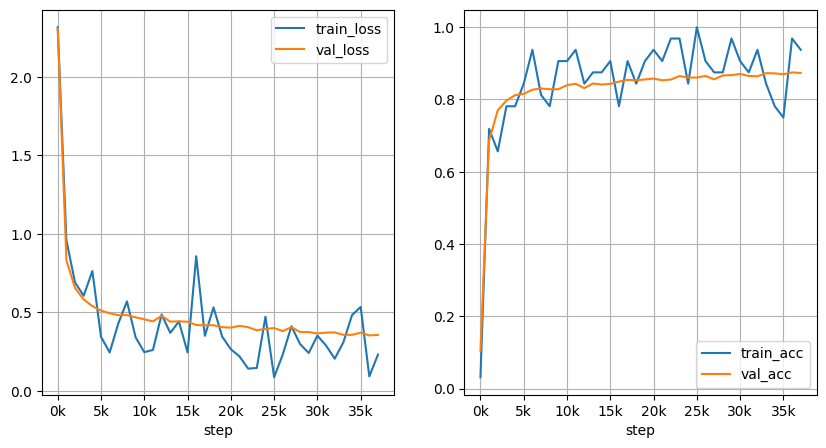

In [30]:
# 画学习曲线的函数，其中记录的训练和验证信息将用来绘制学习曲线图
def plot_learning_curves(record_dict, sample_step=1000):
    # 从传入的字典中获取训练和验证的记录
    # "train" 和 "val" 字典分别对应训练和验证过程中的各项指标
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]  # 对训练记录按step抽样
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")  # 对验证记录按step处理
    
    # 获取训练数据中最后一个step的值，用于确定x轴的范围
    last_step = train_df.index[-1]  # 最后一步的步数

    # 打印训练和验证集的准确率数据，供调试查看
    print(train_df['acc'])
    print(val_df['acc'])

    # 创建子图：画几张图，分别显示不同的指标（例如损失和准确率）
    # fig_num 是要绘制的图的数量，这里通过列数来决定（假设训练和验证的指标列数相同）
    fig_num = len(train_df.columns)  # 根据训练数据的列数来决定需要多少个子图
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))  # 创建子图

    # 遍历每一个列，绘制每个指标的学习曲线
    for idx, item in enumerate(train_df.columns):
        # 绘制训练集和验证集对应指标的学习曲线
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")  # 绘制训练集的曲线
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")  # 绘制验证集的曲线
        
        axs[idx].grid()  # 显示网格，便于观察
        axs[idx].legend()  # 显示图例，标明曲线的含义
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))  # 设置x轴刻度，步数每5000一个刻度
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000)))  # 设置x轴标签，转换成每千步为单位
        axs[idx].set_xlabel("step")  # 设置x轴的标签为“step”

    # 显示图形
    plt.show()

# 调用绘图函数，传入记录的数据字典
plot_learning_curves(record)  # 横坐标是steps
